# Figure 5: Quantitative representation of trans-splicing prevalence

**Summary:**<br>

This notebook compiles the scripts that were used to generate the Figure 5.

- **Panel a:** Unidentified reads possess an average lower base quality

- **Panel b:** SL and hairpin reads are preferentially found near ATG sites

- **Panel c:** Different modes of trans-splicing


---
<br>



## Import libraries

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import pysam
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator
from matplotlib.patches import Rectangle
from dna_features_viewer import GraphicFeature, GraphicRecord

## Settings for saving figures as pdf

In [14]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Opening Dataset file

In [15]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv('dataset_+SL_+hairpin.tsv', sep='\t')

In [16]:
genes_start = pd.read_csv('SL_&_mimic_positions.tsv', sep='\t')

---

<br>

# Panel a: unidentified reads possess lower base quality in average

In [5]:
# store alignment files in dictionnary for easier manipulation
run_files = {}

runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6', 'SL1_1', 'NP_1', 'NP_2', 'NP_3', 'NP_4', 'NP_5']

for ID in runs:

    file = f'/Volumes/elegans/rna_sequencing/{ID}/{ID}-transcriptome_sorted.bam'
    run_files[ID] = pysam.AlignmentFile(file,'rb')

In [6]:
# Code reused from notebook corresponding to Figure 1.

def avgNestedLists(nested_vals):

    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output


def mean_qualities(dico):

    aligned = []
    unaligned = []

    for ID in ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6', 'SL1_1', 'NP_1', 'NP_2', 'NP_3', 'NP_4', 'NP_5']:

        alignments = run_files[ID]

        for iso in dico:

            selected_reads = dico[iso]

            for read in alignments.fetch(iso):

                if not read.is_unmapped and not read.is_secondary and not read.is_supplementary and read.seq is not None:

                    quali = read.query_qualities
                    name = read.query_name

                    if quali is not None and name in selected_reads:

                        start = read.query_alignment_start
                        end = read.query_alignment_end

                        # aligned
                        aligned_qual = list(quali[start:end])

                        if len(aligned_qual) > 31:
                            aligned.append(aligned_qual)

                        # unaligned
                        sc_qual = list(quali[:start])
                        sc_qual.reverse()

                        if len(sc_qual) > 31:
                            unaligned.append(sc_qual)

    # averaged values
    avgAligned = avgNestedLists(aligned)

    avgUnaligned = avgNestedLists(unaligned)
    avgUnaligned.reverse()

    # base quality on Y axis
    avg = avgUnaligned + avgAligned

    # X axis positions
    xUnaligned = [i for i in range(-len(avgUnaligned), 1)]
    xAligned = [i for i in range(0, len(avgAligned))]

    yUnaligned = avg[:len(avgUnaligned)+1]
    yAligned = avg[len(avgUnaligned):]

    return xUnaligned, xAligned, yUnaligned, yAligned



In [7]:
# Reads associated with an SL1

sl = dataset[(dataset['ROBUST_SL']=='FOUND') & (dataset['HAIRPIN_SEARCH']=='NOT FOUND')].sample(n=250000)
sl_dict = sl.groupby('isoform')['read'].apply(list).to_dict()
sl_qual = mean_qualities(sl_dict)

# Reads associated with an hairpin

hairpin = dataset[(dataset['ROBUST_SL']=='NOT FOUND') & (dataset['HAIRPIN_SEARCH']=='FOUND')].sample(n=250000)
hairpin_dict = hairpin.groupby('isoform')['read'].apply(list).to_dict()
hairpin_qual = mean_qualities(hairpin_dict)

# Reads with no SL1 or hairpin found

unidentified = dataset[(dataset['ROBUST_SL']=='NOT FOUND') & (dataset['HAIRPIN_SEARCH']=='NOT FOUND')].sample(n=250000)
unidentified_dict = unidentified.groupby('isoform')['read'].apply(list).to_dict()
unidentified_qual = mean_qualities(unidentified_dict)

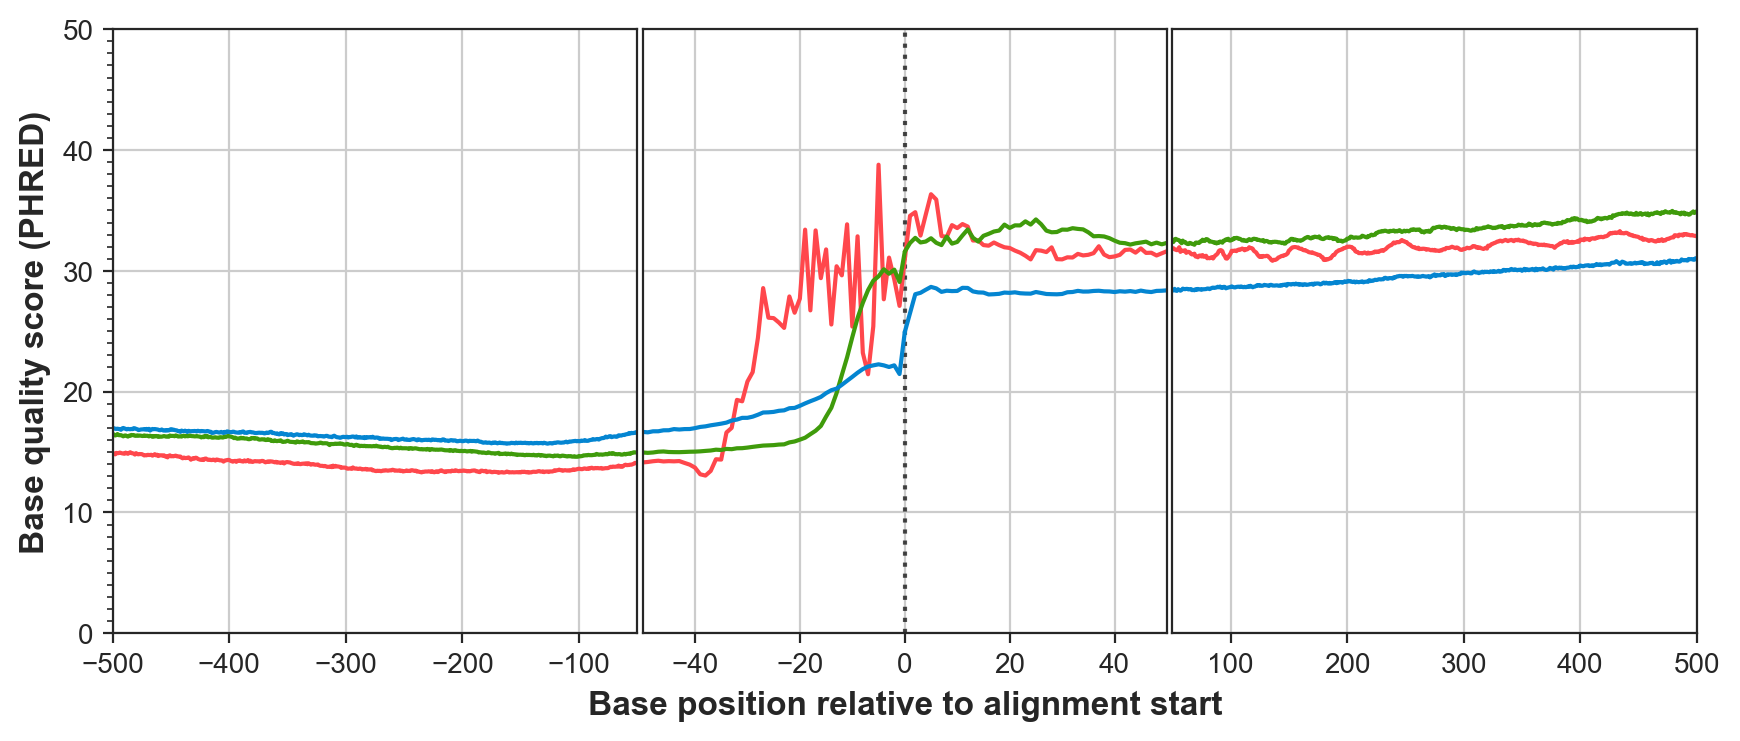

In [8]:
%matplotlib inline

# initializing plot settings
sns.set_style('whitegrid', {'axes.edgecolor': '.15', 'axes.linewidth': '1.5', "xtick.major.size": 8, "ytick.major.size": 8, "xtick.minor.size": 5, "ytick.minor.size": 5})
fig, ax = plt.subplots(figsize=(9,4), nrows=1, ncols=3, sharey=True, dpi=200)

# measure base quality across all three different types of reads
sl_xU, sl_xA, sl_yU, sl_yA = sl_qual
hairpin_xU, hairpin_xA, hairpin_yU, hairpin_yA = hairpin_qual
unidentified_xU, unidentified_xA, unidentified_yU, unidentified_yA = unidentified_qual


# unaligned region
ax[0].plot(sl_xU, sl_yU, color='#ff474c', alpha=1, label='Unaligned region',linewidth=1.5)
ax[0].plot(hairpin_xU, hairpin_yU, color='#3f9b0b', alpha=1, label='Unaligned region',linewidth=1.5)
ax[0].plot(unidentified_xU, unidentified_yU, color='#0485d1', alpha=1, label='Unaligned region',linewidth=1.5)
ax[0].set_xlim(-500,-50)
ax[0].tick_params(axis='y', which='both', left=True)
ax[0].yaxis.set_minor_locator(MultipleLocator(1))
ax[0].tick_params(axis='x', which='major', bottom=True)
ax[0].set_ylabel('Base quality score (PHRED)', weight='bold', size=12)

# transition region
ax[1].plot(sl_xU[-51:], sl_yU[-51:], color='#ff474c', alpha=1, label='Unaligned region',linewidth=1.5)
ax[1].plot(sl_xA[:51], sl_yA[:51], color='#ff474c', alpha=1, label='Aligned region', linewidth=1.5)
ax[1].plot(hairpin_xU[-51:], hairpin_yU[-51:], color='#3f9b0b', alpha=1, label='Unaligned region',linewidth=1.5)
ax[1].plot(hairpin_xA[:51], hairpin_yA[:51], color='#3f9b0b', alpha=1, label='Aligned region', linewidth=1.5)
ax[1].plot(unidentified_xU[-51:], unidentified_yU[-51:], color='#0485d1', alpha=1, label='Unaligned region',linewidth=1.5)
ax[1].plot(unidentified_xA[:51], unidentified_yA[:51], color='#0485d1', alpha=1, label='Aligned region', linewidth=1.5)
ax[1].vlines(0, 0, 50, 'black', alpha=0.7, linewidth=1.5, linestyle='dotted')
ax[1].set_xlim(-50, 50)
ax[1].tick_params(axis='x', which='major', bottom=True)
ax[1].set_xlabel('Base position relative to alignment start', weight='bold', size=12)

# aligned region
ax[2].plot(sl_xA[51:], sl_yA[51:], color='#ff474c', alpha=1, label='Aligned region', linewidth=1.5)
ax[2].plot(hairpin_xA[51:], hairpin_yA[51:], color='#3f9b0b', alpha=1, label='Aligned region', linewidth=1.5)
ax[2].plot(unidentified_xA[51:], unidentified_yA[51:], color='#0485d1', alpha=1, label='Aligned region', linewidth=1.5)
ax[2].set_xlim(50, 500)
ax[2].tick_params(axis='x', which='major', bottom=True)

# plot settings
plt.ylim(0,50)
plt.subplots_adjust(left=0.1, bottom=None, right=0.98, top=None, wspace=0.01, hspace=None)

# save
plt.savefig('Fig5.a-base_quality_read_categories.pdf', dpi=800, bbox_inches='tight')


<font size="4">**Figure 5.a:**<br></font>
Reads for which neither SL sequence nor endogenous hairpin could be found tend to have lower overall sequence quality. Each mRNA read from our direct cDNA experiment was classified as SL, hairpin or neither. We randomly selected 250,000 reads from each category and plotted the average Qscore around the end of the alignment start position.

<br>

# Panel b: SL and hairpins are preferentially found near ATG sites

In [17]:
most_exp_pos = genes_start.sort_values('total', ascending=False).groupby('gene').head(1)

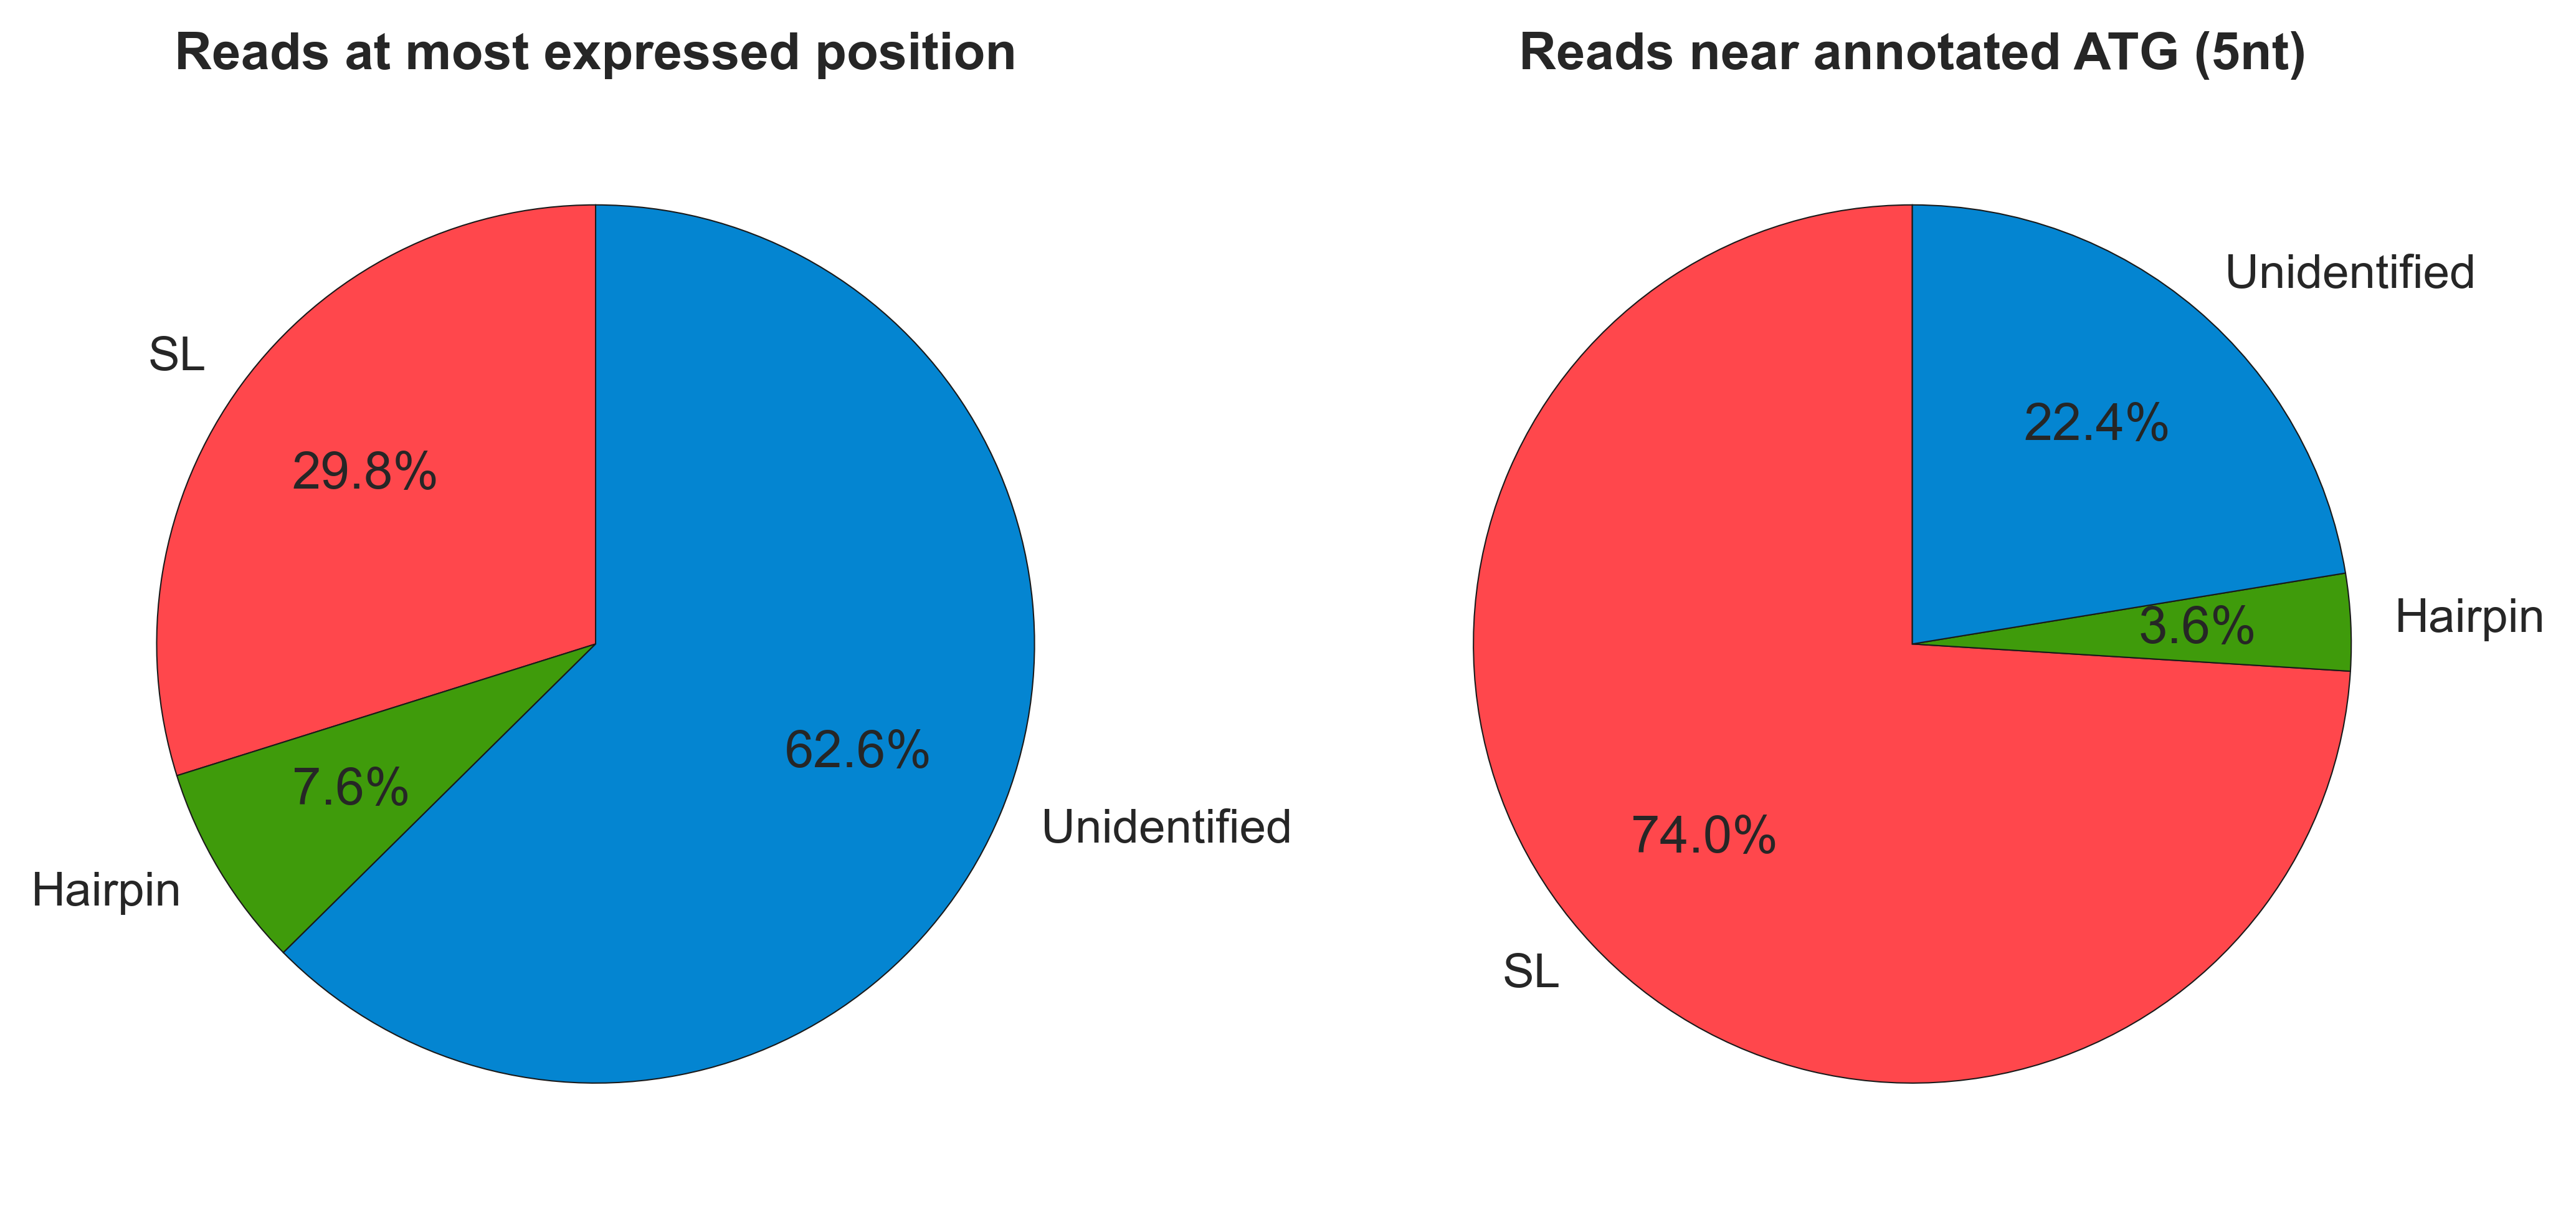

In [18]:
# plot settings
%matplotlib inline
sns.set()
fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1, dpi=500)

# read categories name and colors
labels = ['SL', 'Hairpin', 'Unidentified']
colors = ['#ff474c', '#3f9b0b', '#0485d1' ]


### Pie plot based on all reads

_sl = sum(genes_start['SL'])
_hairpin = sum(genes_start['hairpin'])
_unid = sum(genes_start['unidentified'])

p1 = ax[0].pie([_sl, _hairpin, _unid], labels=labels, colors=colors, 
               autopct='%1.1f%%', startangle=90, pctdistance=0.65, 
               wedgeprops={'linewidth': 0.3, 'linestyle': 'solid', 'edgecolor':'k','antialiased': True})

ax[0].set_title('Reads at most expressed position', weight='bold')


### Pie plot based on reads near an annotated ATG (5nt)

_sl = sum(most_exp_pos['SL'])
_hairpin = sum(most_exp_pos['hairpin'])
_unid = sum(most_exp_pos['unidentified'])

p2 = ax[1].pie([_sl, _hairpin, _unid], labels=labels, colors=colors, 
               autopct='%1.1f%%', startangle=90, pctdistance=0.65, 
               wedgeprops={'linewidth': 0.3, 'linestyle': 'solid', 'edgecolor':'k','antialiased': True})

ax[1].set_title('Reads near annotated ATG (5nt)', weight='bold')

# save figure
plt.savefig('Fig5.b-pie_plots.pdf', dpi=800, bbox_inches='tight')

<font size="4">**Figure 5.b:**<br></font>
Repartition of reads according to 5' hairpin detection. **left:** over all reads, **right:** reads near annotated start positions.

<br>

# Panel c: different modes of trans-splicing

### 1. Functions for plotting single gene

In [19]:
# Convert isoform name into gene name
# ex: MTCE.35.1 -> MTCE.35

def isoform_to_gene(isoform):
    
    match = re.search(r"\w+.\d+", isoform)

    if match is not None:
        return match.group(0)
    else:
        return None

In [20]:
# open file
ATG = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/CDS_start_positions.tsv', sep='\t')

# convert transcript name to gene name
ATG['gene'] = ATG['transcript'].apply(lambda x: isoform_to_gene(x))

# create dict
ATG_positions = {}
for gene, positions in ATG.groupby('gene'):
    pos = list(set(positions['CDS_start']))
    ATG_positions[gene] = pos

In [21]:
# Reference files used for drawing simplified gene model

genesref = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/genes_coordinates.tsv', sep='\t')
refname = genesref.set_index('CDS')['name'].to_dict()

exonslist = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/exon_coordinates.tsv', sep='\t')

In [22]:
# Helper function
# Prevents from drawing exons that overlaps

def OverlappingExons(start, end, exon):
    
    x, y = exon
    
    if x <= start <= y or x <= end <= y:
        return False
    
    else:
        return True


# Function for drawing gene model
# based on dna_features_viewer library
# in case of complicated gene structure, not all exons are representated if they overlap

def GeneStructure(gene, return_coordinates=False):

    # Open reference files
    exonslist = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/exon_coordinates.tsv', sep='\t')
    geneslist = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/genes_coordinates.tsv', sep='\t')

    # Select exons for gene of interest and remove duplicates
    exonslist = exonslist.loc[exonslist['gene'] == gene].drop_duplicates(['start', 'end']).sort_values('start')

    # Process exons
    exons_set = []
    gene_structure = []

    for _, exon in exonslist.iterrows():

        start = exon['start']
        end = exon['end']

        set_size = len(exons_set)

        if set_size == 0:
            exons_set.append((start, end))

        else:
            if all([OverlappingExons(start, end, exons_set[n]) for n in range(set_size)]):
                exons_set.append((start, end))

    color = {'+': '#ffd1df', '-': '#95d0fc'}
    strand = exonslist['strand'].unique()[0]

    i = 1
    for exon in exons_set:

        start, end = exon

        if strand == '-' and i == 1:
            strd = -1
            i += 1

        elif strand == '+' and i == len(exons_set):
            strd = +1
            i += 1

        else:
            strd = 0
            i += 1

        gene_structure.append(GraphicFeature(start=start, end=end, strand=strd, color=color[strand]))

    # get start / end coordinates for the gene
    gene_start = geneslist.loc[geneslist['CDS'] == gene, 'start'].values[0]
    gene_end = geneslist.loc[geneslist['CDS'] == gene, 'end'].values[0]

    # Calculate isoform length
    length = gene_end - gene_start

    # Create feature to be plotted
    record = GraphicRecord(first_index=gene_start, sequence_length=length, features=gene_structure)
    
    

    if return_coordinates is False:
        return record
    else:
        return gene_start, length, record


In [23]:
# main function for plotting gene start representated in our dataset
# for each gene, the first aligned based of a read is considered the "start position"
# for each representated start position (X axis), we plot the number of reads (Y axis)

def gene_start_positions(gene, output=None, min_reads=None):

    # get common name 
    name = f'{refname[gene]} ({gene})' if refname[gene] == refname[gene] else gene

    # plot setting ----------------------

    %matplotlib inline

    sns.set_style("white")
    fig = plt.figure(figsize=(8, 5), dpi=300) # constrained_layout=True

    grid = fig.add_gridspec(2, 1, 
                           height_ratios=[1.5, 6],
                           top=1.05, bottom=0.08, right=0.95, left=0.08, hspace=0.1, wspace=0)

    # Gene structure ----------------------

    axis1 = fig.add_subplot(grid[0])
    axis1.grid(False)
    axis1.axis('off')

    start, length, record = GeneStructure(gene, return_coordinates=True)
    record.plot(ax=axis1)


    #### computing --------------------------
    
    gene_df = genes_start[genes_start['gene'] == gene]

    #### plotting --------------------------

    axis2 = fig.add_subplot(grid[1], sharex = axis1)
    
    x = list(gene_df['position'])
    y = list(gene_df['total'])

    r = [i/100 for i in list(gene_df['%SL'])]
    g = [i/100 for i in list(gene_df['%hairpin'])]
    b = [i/100 for i in list(gene_df['%unidentified'])]
    col= list(zip(r, g, b))
    
    plot = axis2.scatter(x, y ,c=col, s=50, alpha=1, edgecolor='k', linewidth=0.1)
    
    
    # ATG ------
    
    if gene in ATG_positions:
    
        ATG = ATG_positions[gene]
        _max = max(y)*1.1
        
        for _atg in ATG:
            axis2.vlines(_atg, 0, _max, colors='k', linestyles='dotted', zorder=-1)
            axis2.set_ylim(top=_max)
                
    # settings ------            

    axis2.set_ylabel('number of reads', weight='bold')
    axis2.set_xlabel('genomic start position (bp)', weight='bold')
    axis2.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                      labelleft=True, labeltop=False, labelright=False, labelbottom=True)

    axis2.xaxis.set_major_locator(plt.MaxNLocator(7))
    axis2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    axis2.set_xlim(start-(0.1*length), (start+(length*1.1)))
    
    fig.suptitle(name, weight='bold', style='italic', size=14)
    
    if output:
        plt.savefig(output, bbox_inches='tight', dpi=800)
        

<br>

### 2. Functions for plotting operon structures

In [24]:
def OperonStructure(gene1, gene2, return_coordinates=False):

    # Open reference files
    exonslist = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/exon_coordinates.tsv', sep='\t')
    geneslist = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/genes_coordinates.tsv', sep='\t')
    
    
    gene_structure = []
    
    starts={}
    ends={}
    
    for gene in [gene1, gene2]:
        
        # Select exons for gene of interest and remove duplicates
        _exonslist = exonslist.loc[exonslist['gene'] == gene].drop_duplicates(['start', 'end']).sort_values('start')
        
        # Process exons
        exons_set = []

        for _, exon in _exonslist.iterrows():

            start = exon['start']
            end = exon['end']

            set_size = len(exons_set)

            if set_size == 0:
                exons_set.append((start, end))

            else:
                if all([OverlappingExons(start, end, exons_set[n]) for n in range(set_size)]):
                    exons_set.append((start, end))

        color = {'+': '#ffd1df', '-': '#95d0fc'}
        strand = _exonslist['strand'].unique()[0]

        i = 1
        for exon in exons_set:

            start, end = exon

            if strand == '-' and i == 1:
                strd = -1
                i += 1

            elif strand == '+' and i == len(exons_set):
                strd = +1
                i += 1

            else:
                strd = 0
                i += 1

            gene_structure.append(GraphicFeature(start=start, end=end, strand=strd, color=color[strand]))

            
        # get start / end coordinates for the gene
        gene_start = geneslist.loc[geneslist['CDS'] == gene, 'start'].values[0]
        starts[gene]=gene_start
        
        # gene end
        gene_end = geneslist.loc[geneslist['CDS'] == gene, 'end'].values[0]
        ends[gene]=gene_end
    

    _min = min(starts.values())
    _max = max(ends.values())
    length = _max - _min

    # Create feature to be plotted
    record = GraphicRecord(first_index=_min, sequence_length=length, features=gene_structure)

    
    if return_coordinates is False:
        return record
    else:
        return gene_start, length, record


In [25]:
# main function for plotting gene start representated in our dataset
# for each gene, the first aligned based of a read is considered the "start position"
# for each representated start position (X axis), we plot the number of reads (Y axis)

def plot_operon(gene1, gene2, output=None, min_reads=None):

    # get common name 
    name1 = f'{refname[gene1]} ({gene1})' if refname[gene1] == refname[gene1] else gene1
    name2 = f'{refname[gene2]} ({gene2})' if refname[gene2] == refname[gene2] else gene2

    # plot setting ----------------------

    %matplotlib inline

    sns.set_style("white")
    fig = plt.figure(figsize=(12, 5), dpi=300) # constrained_layout=True

    grid = fig.add_gridspec(2, 1, 
                           height_ratios=[1, 4],
                           top=1.05, bottom=0.08, right=0.95, left=0.08, hspace=0.1, wspace=0)

    # Gene structure ----------------------

    axis1 = fig.add_subplot(grid[0])
    axis1.grid(False)
    axis1.axis('off')

    start, length, record = OperonStructure(gene1,gene2, return_coordinates=True)
    record.plot(ax=axis1)

    #### computing --------------------------
    
    gene1_df = genes_start[genes_start['gene'] == gene1]
    gene2_df = genes_start[genes_start['gene'] == gene2]

    #### plotting --------------------------

    axis2 = fig.add_subplot(grid[1], sharex = axis1)
    _max=0
    for df in [gene1_df, gene2_df]:
        x = list(df['position'])
        y = list(df['total'])
        r = [i/100 for i in list(df['%SL'])]
        g = [i/100 for i in list(df['%hairpin'])]
        b = [i/100 for i in list(df['%unidentified'])]
        col= list(zip(r, g, b))
        plot = axis2.scatter(x, y ,c=col, s=50, alpha=1, edgecolor='k', linewidth=0.1)
        
        #update max y value
        if max(y)>_max:
            _max=max(y)
    
    # ATG ------
    
    for gene in [gene1, gene2]:
        if gene in ATG_positions:

            ATG = ATG_positions[gene]
            _max = max(y)*1.1

            for _atg in ATG:
                axis2.vlines(_atg, _max*-0.05, _max*1.02, colors='k', linestyles='dotted', zorder=-1)

    # settings ------            

    axis2.set_ylabel('number of reads', weight='bold')
    axis2.set_xlabel('genomic start position (bp)', weight='bold')
    axis2.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                      labelleft=True, labeltop=False, labelright=False, labelbottom=True)

    axis2.xaxis.set_major_locator(plt.MaxNLocator(7))
    axis2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    axis2.set_xlim(start-(0.1*length), (start+(length*1.1)))
    
    axis2.set_ylim(_max*-0.05, _max*1.02)
    
    fig.suptitle(f'{name1} & {name2}', weight='bold', style='italic', size=14)
    
    if output:
        plt.savefig(output, bbox_inches='tight', dpi=800)
    

<br>

### 3. Plotting color legend

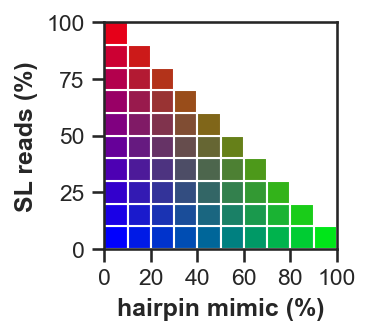

In [18]:
# This code allows to generate the colormap used in Figure 3.e

# Red = 100% SL reads
# Green = 100% mimic reads
# Blue = 100% unidentified reads

%matplotlib inline

sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2,2), dpi=150)

for i in range(0,100,10):
    for j in range(0,100,10):
        
        # set Red value
        R = i/100 if i>0 else 0
        
        # set Green value
        G = j/100 if j>0 else 0
        
        if i+j < 100:
            
            # set Blue value
            B = 1-(R+G)
            
            # draw corresponding color
            ax.add_patch(Rectangle((j, i), 10, 10, facecolor=(R,G,B), edgecolor=None))



plt.tick_params(axis='both', which ='both', left=True, bottom=True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))


plt.xlim(0,100)
plt.ylim(0,100)
plt.ylabel('SL reads (%)', weight='bold')
plt.xlabel('hairpin mimic (%)', weight='bold')
        
plt.savefig('Fig5.c-color_legend.pdf', dpi=500)

<br>

### 4. Genes examples

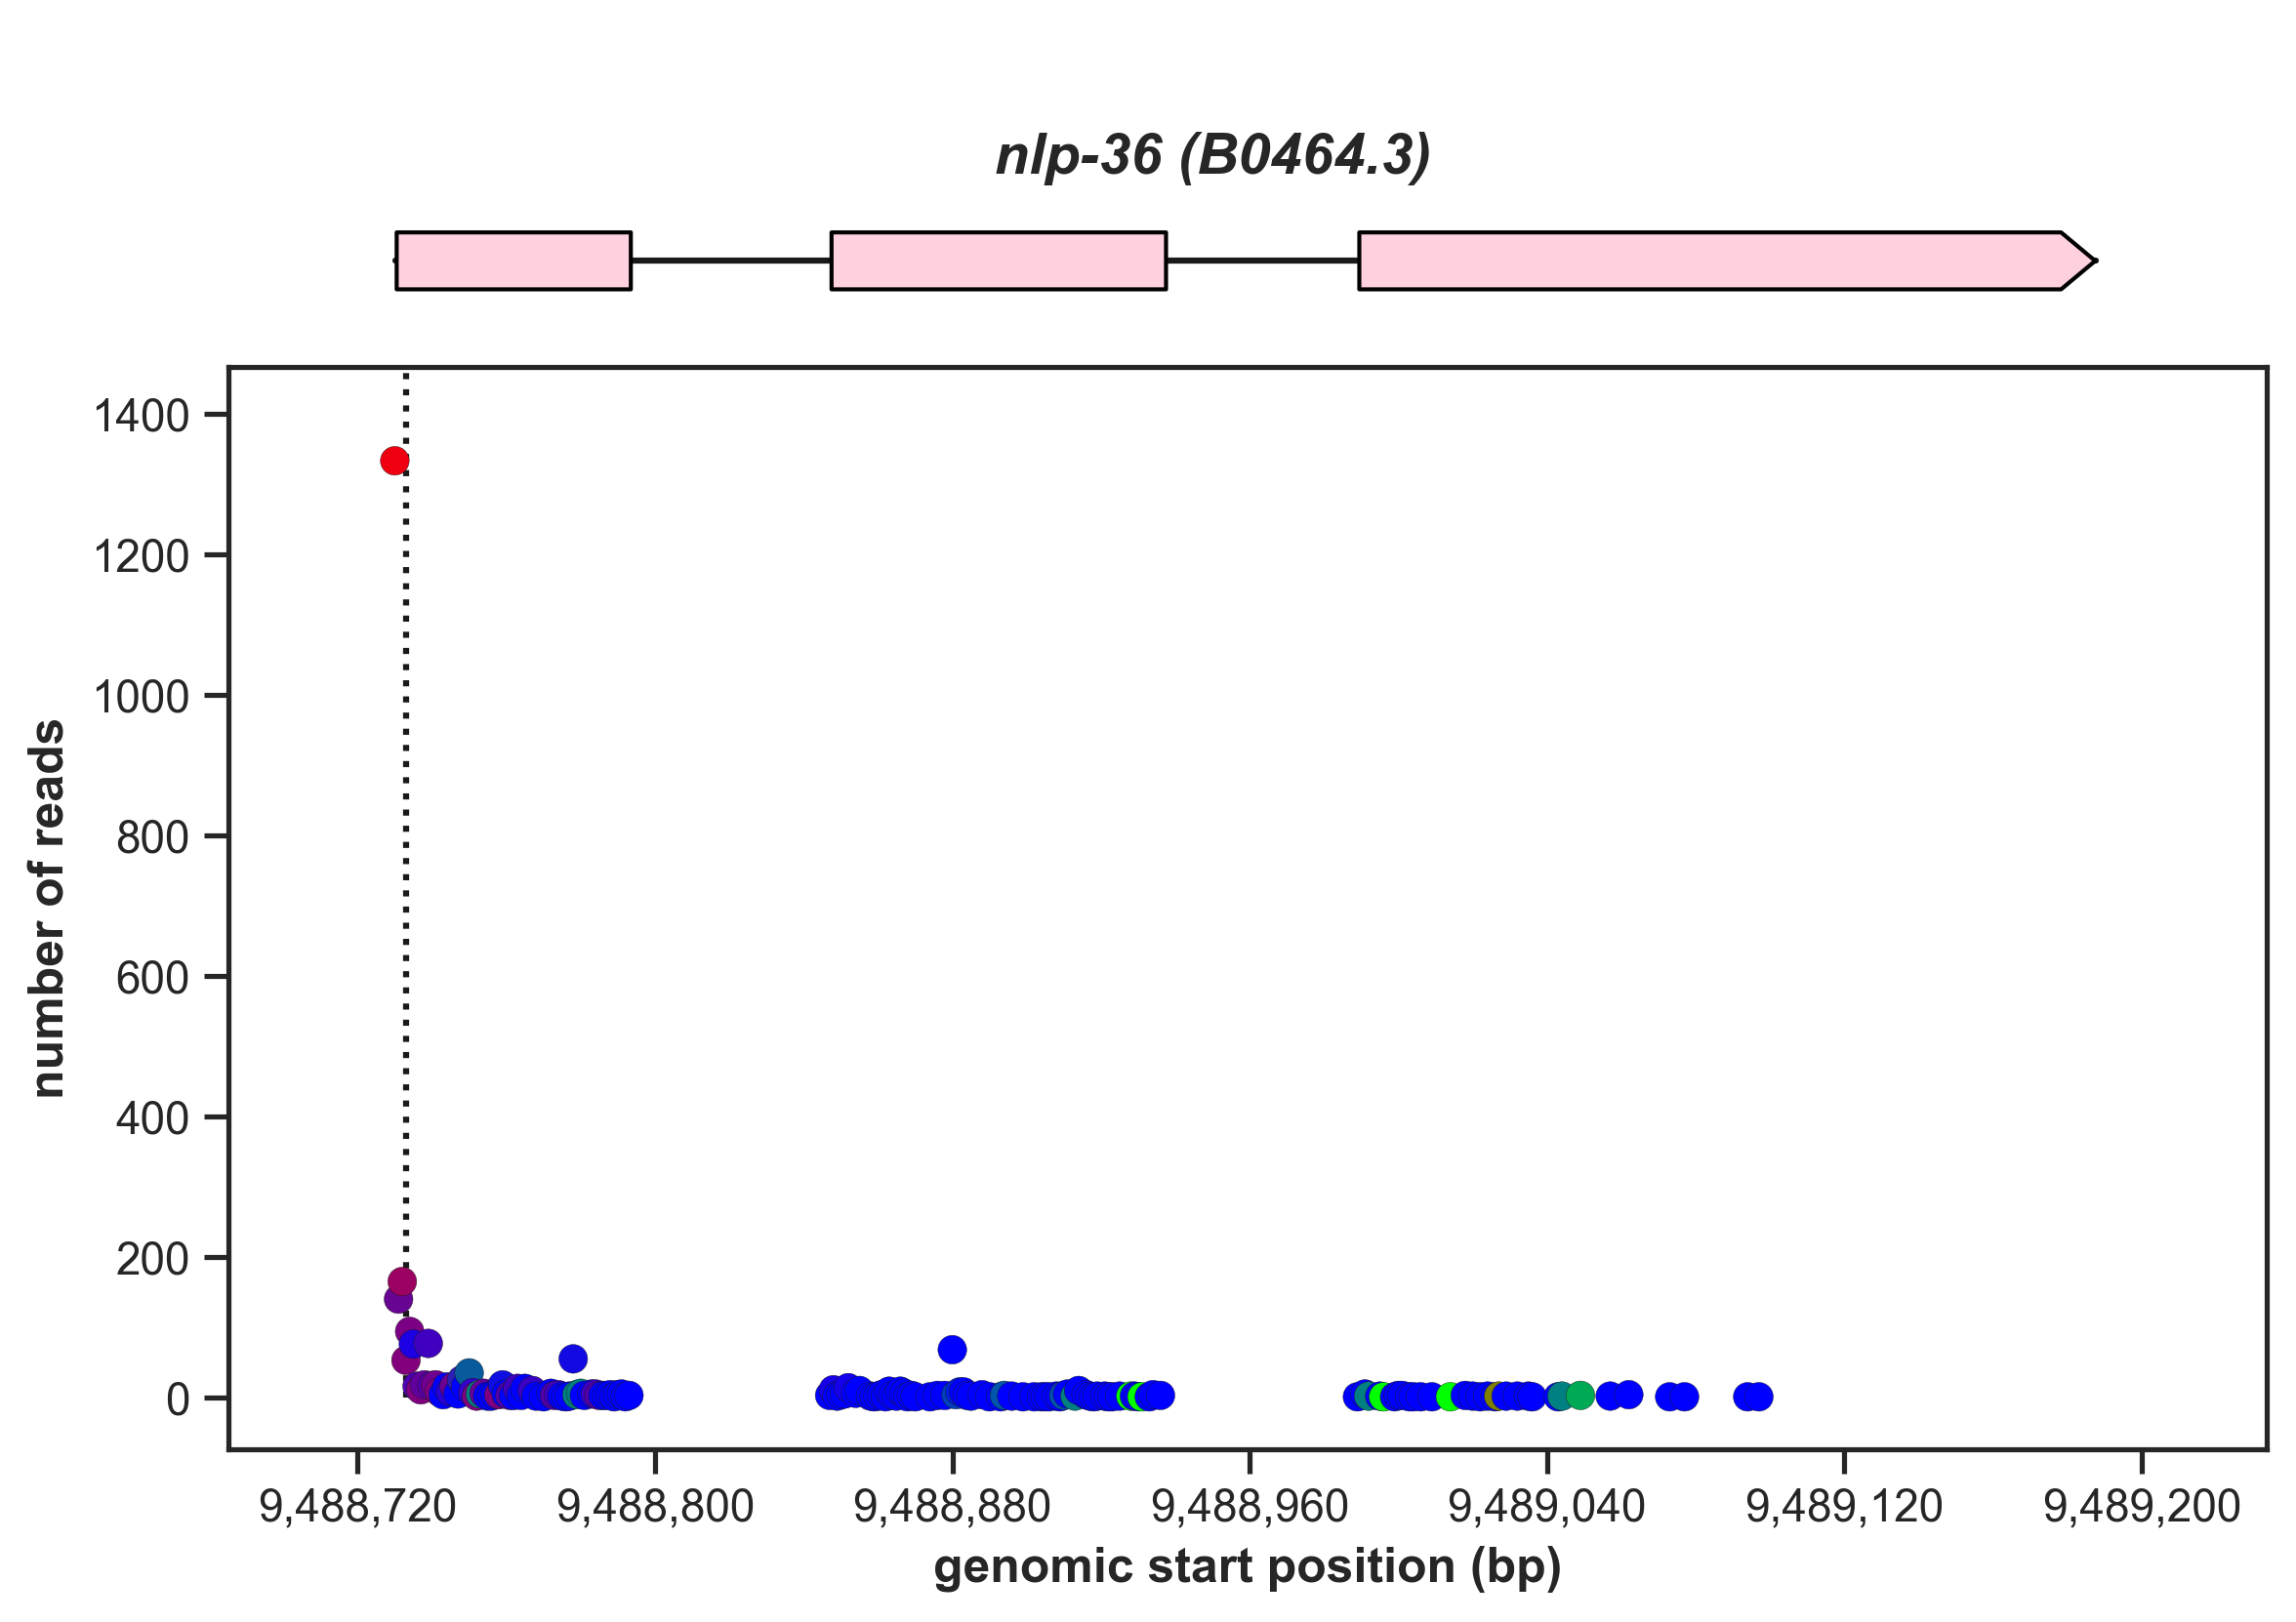

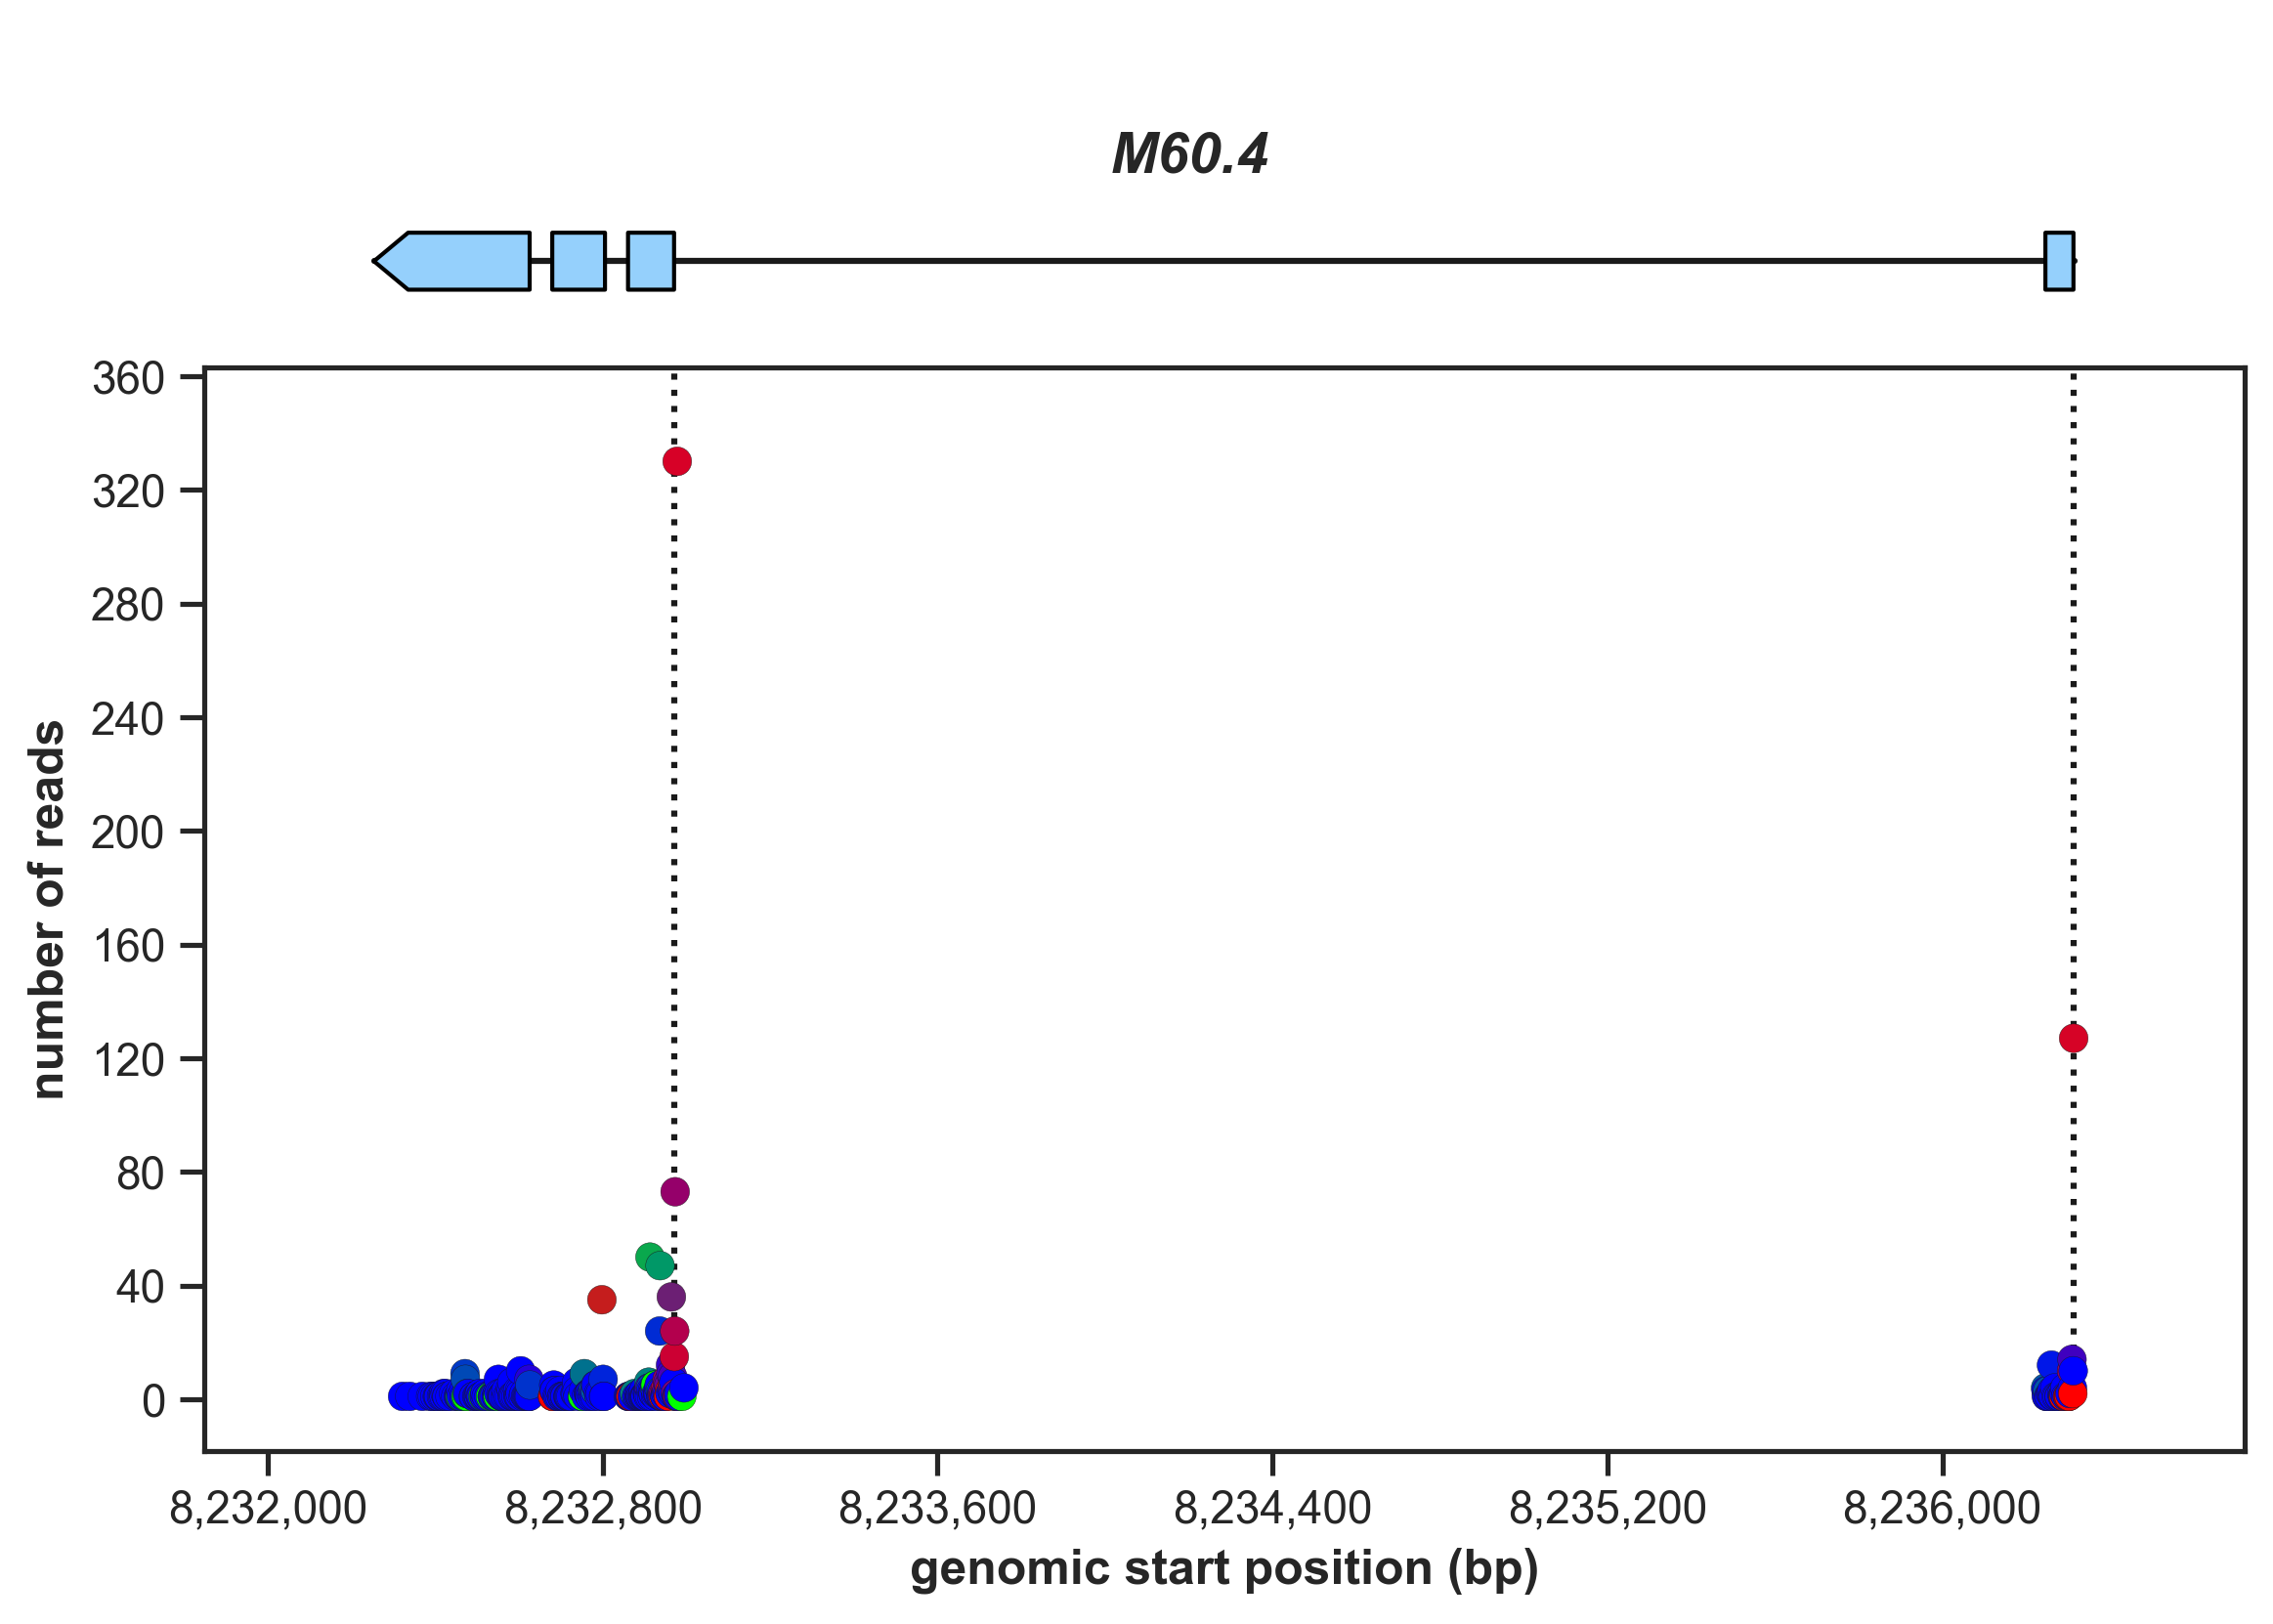

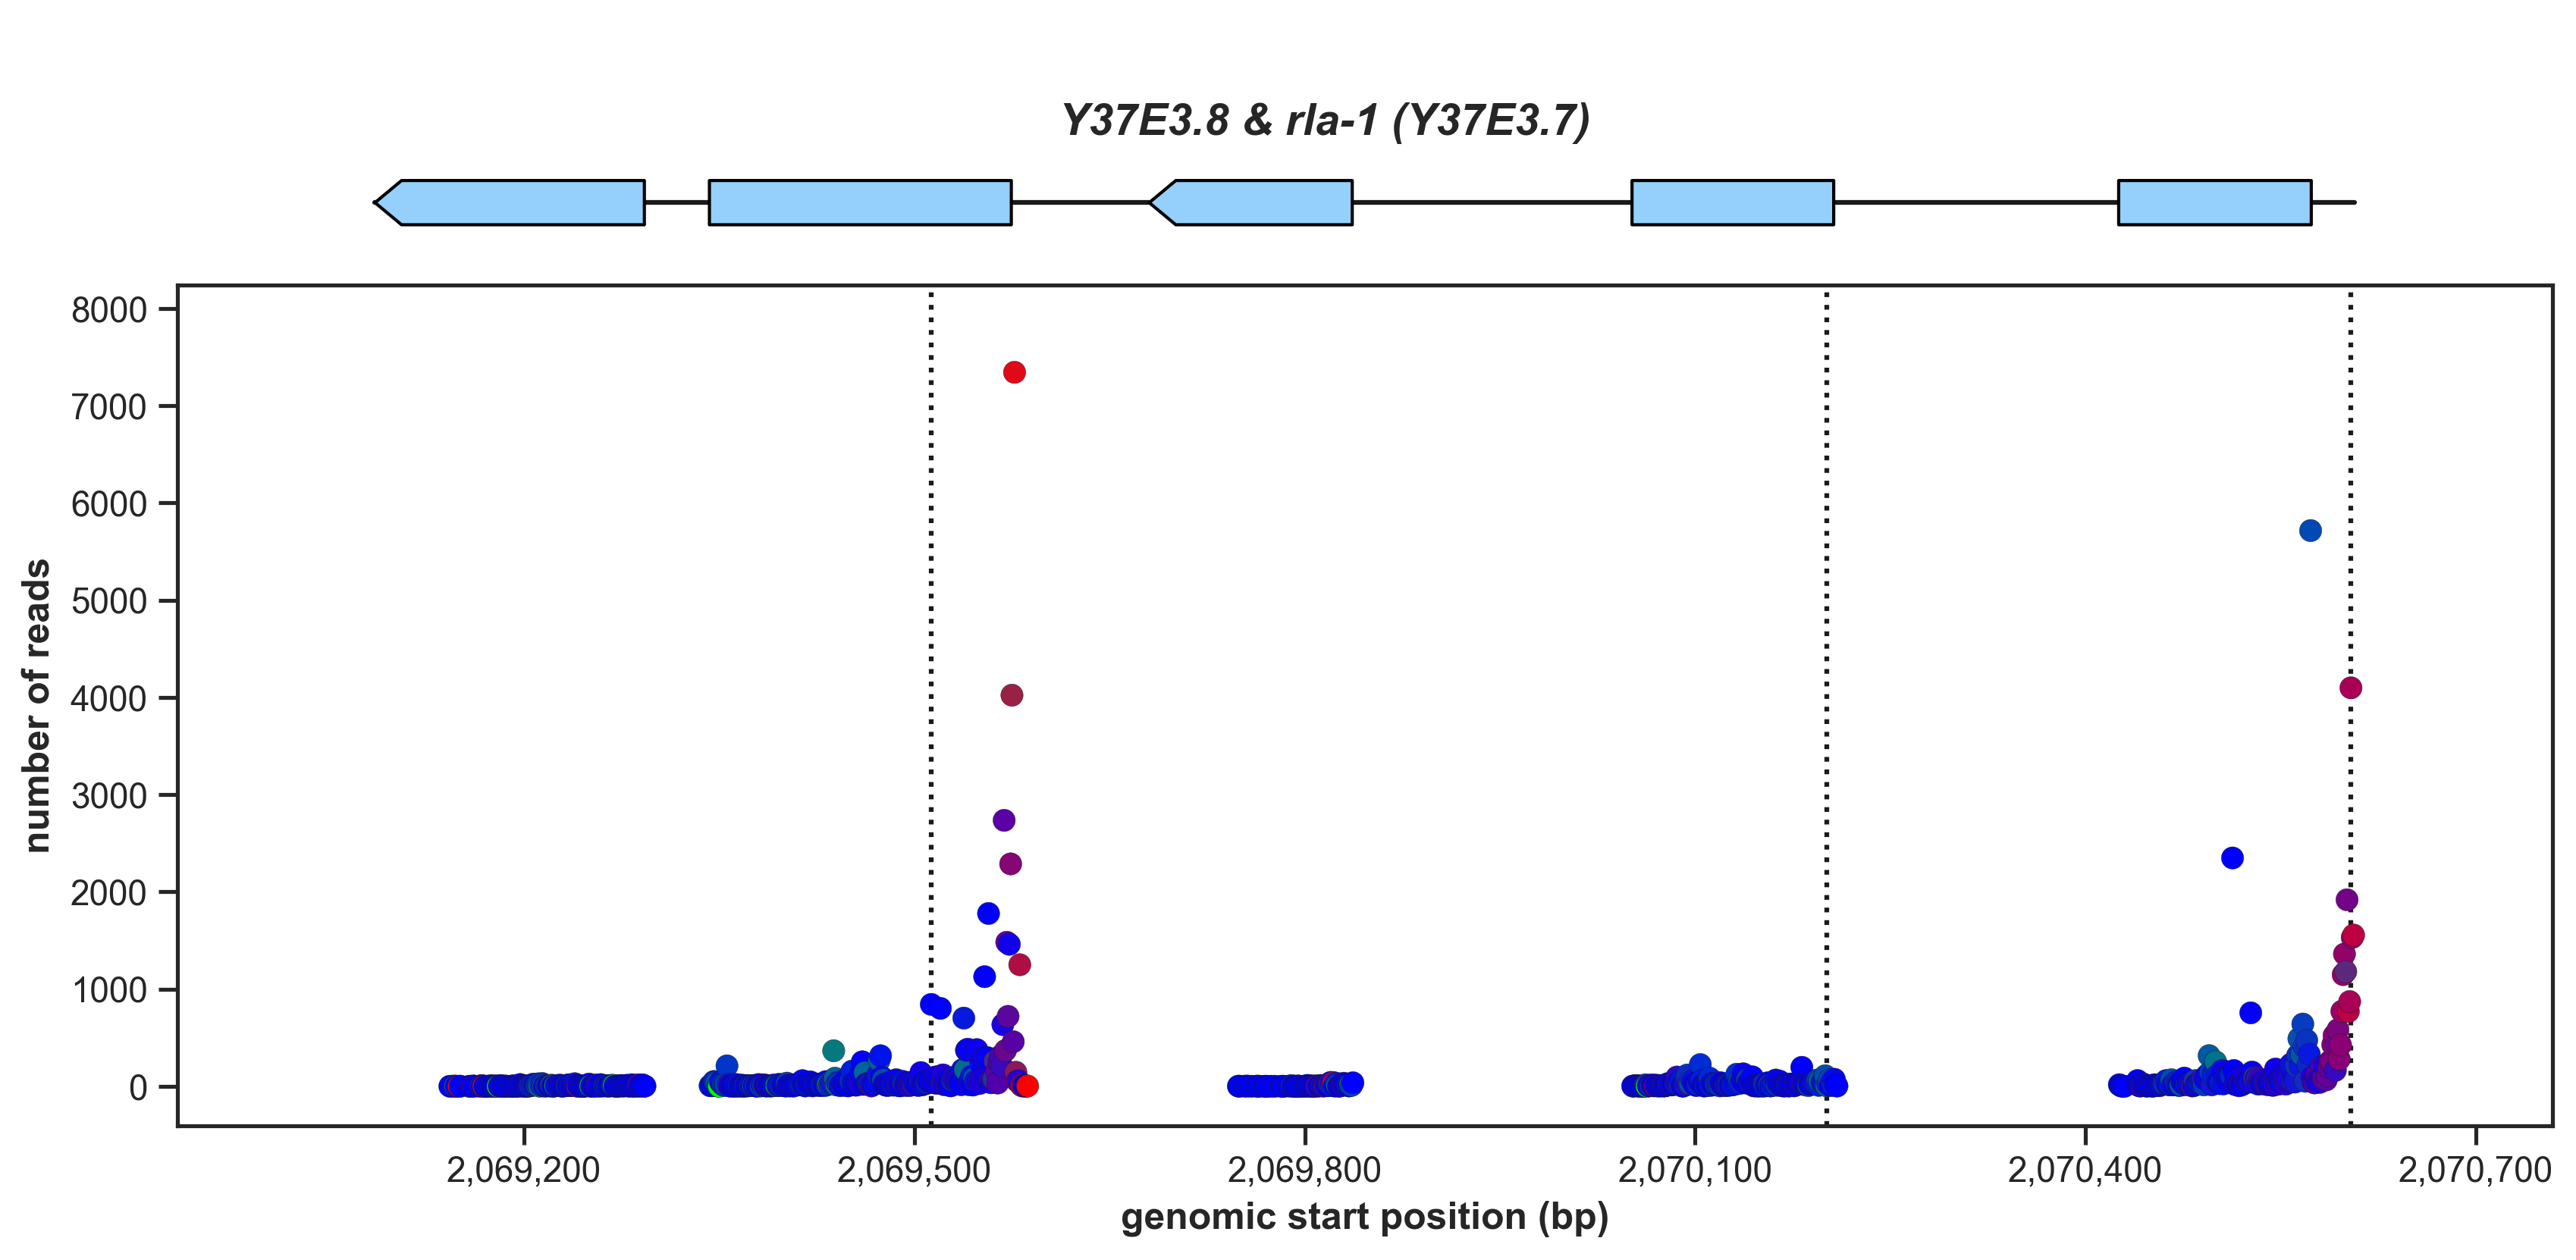

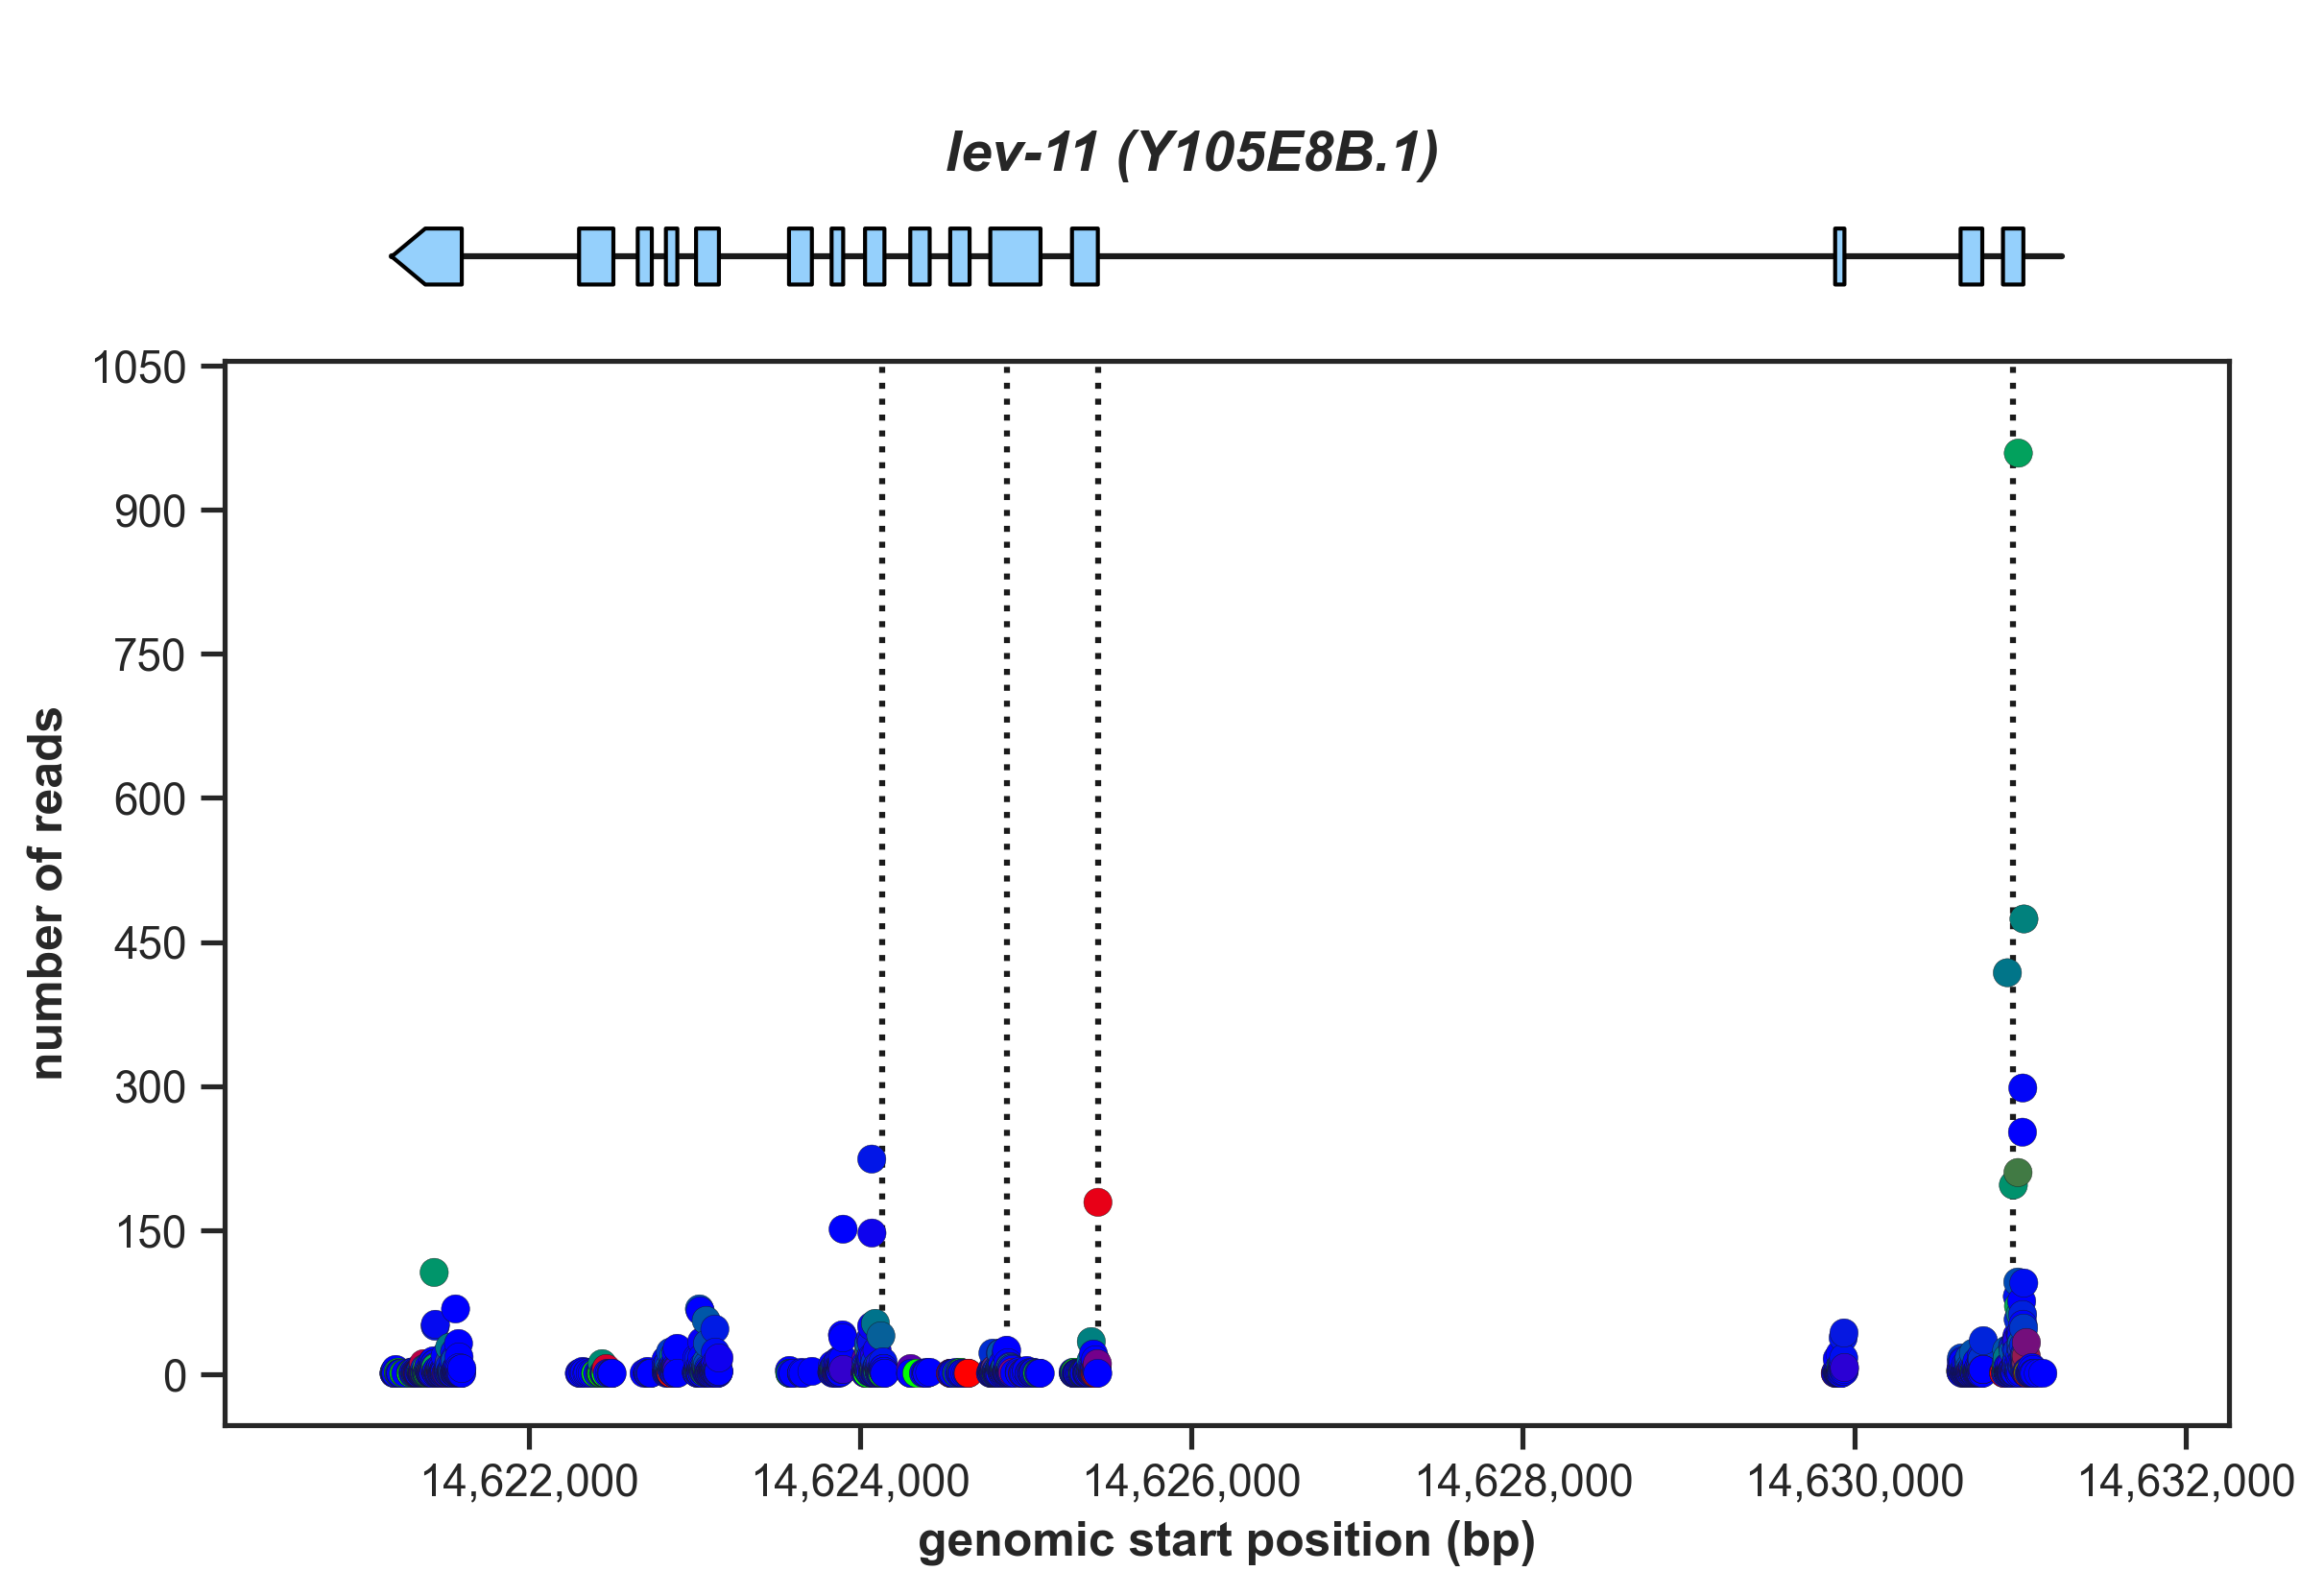

In [26]:
# Single SL1 promotor: nlp-36 (B0464.3)
gene_start_positions('B0464.3', output='Fig5.c-single_SL1_promoter.png')
plt.show()


# Multiple SL1 promotors: M60.4
gene_start_positions('M60.4', output='Fig5.c-multiple_SL1_promoters.png')
plt.show()


# SL1/SL2 operon: Y37E3.8 & Y37E3.7
plot_operon('Y37E3.8', 'Y37E3.7', output='Fig5.c-operon.png')
plt.show()


# Differentially trans-spliced promoters : lev-11 (Y105E8B.1)
gene_start_positions('Y105E8B.1', output='Fig5.c-lev-11.png')
plt.show()

<font size="4">**Figure 5.c:**<br></font>
Schematic representation of various genes showing different modes of trans-splicing. Each alignment start position observed was plotted at the corresponding genomic position with the number of supporting reads. The dots are colored according to the observed trans-splicing events with red indicating a majority of SL reads, green a majority of endogenous hairpin reads and blue reads with no evidence for either.<br>
**nlp-36 (B0464.3):** Single SL1 promotor.
**M60.4:** Multiple SL1 promotors.
**rla-1 (Y37E3.7) & Y37E3.8:** Operon-like system. Upstream gene is SL1 trans-spliced and downstream gene is SL2 trans-spliced. Genes are located 104nt from each other.
**lev-11 (Y105E8B.1):** Differentially trans-spliced promotors. 





